In [0]:
!pip install transformers
!pip install gensim


     |████████████████████████████████| 573kB 4.8MB/s 
     |████████████████████████████████| 3.7MB 58.3MB/s 
     |████████████████████████████████| 890kB 42.1MB/s 
     |████████████████████████████████| 1.0MB 46.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=c1446cf307f8e4a97a6a80e6906ad9db548c54188ae2c2194df0805068e99d75
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import (
    AdamW,
    BertConfig,
    BertTokenizer,
    BertForSequenceClassification,
    XLNetConfig, 
    XLNetForSequenceClassification, 
    XLNetTokenizer,
    XLMConfig, 
    XLMForSequenceClassification, 
    XLMTokenizer,
    RobertaConfig, 
    RobertaForSequenceClassification, 
    RobertaTokenizer,
    DistilBertConfig, 
    DistilBertForSequenceClassification, 
    DistilBertTokenizer,
    AlbertConfig, 
    AlbertForSequenceClassification, 
    AlbertTokenizer,
    XLMRobertaConfig, 
    XLMRobertaForSequenceClassification, 
    XLMRobertaTokenizer,
    get_linear_schedule_with_warmup
)


In [0]:
MODEL_CLASSES = {
    "bert": (BertConfig, BertForSequenceClassification, BertTokenizer),
    "xlnet": (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    "xlm": (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    "roberta": (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer),
    "albert": (AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer),
    "xlmroberta": (XLMRobertaConfig, XLMRobertaForSequenceClassification, XLMRobertaTokenizer),
} 

In [0]:
## Model setup
model_type = 'bert'
model_name = 'bert-base-cased'
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

config = config_class.from_pretrained(model_name, num_labels=50, output_hidden_states=True)
model = model_class.from_pretrained(model_name, config=config)
tokenizer = tokenizer_class.from_pretrained(model_name, do_lower_case=False)


In [0]:
# PARAMETERS
MAX_LEN = 128
batch_size = 32
lr = 4e-5
eps = 1e-8
epochs = 4

In [0]:
ROOT = ""
DATA_PATH = ROOT + 'datasets/'
def get_data(subset='train'):
    texts = []
    for root, folders, files in os.walk(DATA_PATH + '/C50/C50{}'.format(subset)):
        if len(files) == 0:
            continue

        author = root.split('/')[-1]
        for file in files:
            if file.endswith('.txt'):
                with open(os.path.join(root, file), 'r') as f:
                    texts.append({
                        'author': author,
                        'text': f.read(),

                    })
    df = pd.DataFrame(texts)
    unique_authors = sorted(df['author'].unique())
    num_authors = len(unique_authors)
    author_to_id = { unique_authors[i]: i for i in range(num_authors) }
    df = df.assign(author_id=df['author'].apply(lambda a: author_to_id[a]))
    return df

In [0]:
def get_encodings(texts):
    token_ids = []
    attention_masks = []
    for text in texts:
        token_id = tokenizer.encode(text, 
                                    add_special_tokens=True, 
                                    max_length=MAX_LEN,
                                    pad_to_max_length=True)
        token_ids.append(token_id)
    return token_ids



def get_attention_masks(padded_encodings):
    attention_masks = []
    for encoding in padded_encodings:
        attention_mask = [int(token_id > 0) for token_id in encoding]
        attention_masks.append(attention_mask)
    return attention_masks

In [0]:
train_df = pd.read_pickle(DATA_PATH + 'reuters50_train.pkl')
test_df = pd.read_pickle(DATA_PATH + 'reuters50_test.pkl')

In [0]:
train_encodings = get_encodings(train_df.text.values)
train_attention_masks = get_attention_masks(train_encodings)

test_encodings = get_encodings(test_df.text.values)
test_attention_masks = get_attention_masks(test_encodings)


In [0]:
train_input_ids = torch.tensor(train_encodings)
train_masks = torch.tensor(train_attention_masks)
train_labels = torch.tensor(train_df.author_id.values)


test_input_ids = torch.tensor(test_encodings)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_df.author_id.values)

# Create the DataLoader for our training set.
train_data = TensorDataset(train_input_ids, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(test_input_ids, test_masks, test_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
import math 

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def get_confusion_matrix(preds, labels):
    """
    Rows = true labels
    Columns = classified labels
    """
    confusion_matrix = np.zeros((50, 50))
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    for i, label in enumerate(labels):
        pred = preds[i]
        confusion_matrix[label][pred] += 1

    return confusion_matrix

def parse_confusion_matrix(confusion_matrix):
    """
    Rows = labels
    Col0 = tp
    Col1 = fp
    Col2 = fn
    Col3 = tn
    """
    parsed_confusion_matrix = np.zeros((50, 4))
    for i in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[i][i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp 
        tn = confusion_matrix.sum() - tp - fp - fn
        # print(f'Label: {i}, tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}')
        parsed_confusion_matrix[i][0] = tp
        parsed_confusion_matrix[i][1] = fp
        parsed_confusion_matrix[i][2] = fn
        parsed_confusion_matrix[i][3] = tn
    return parsed_confusion_matrix

def calculate_avg_precision(parsed_confusion_matrix):
    """
    Calculates macro average precision
    """
    total_precision = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, fp, _, _ = parsed_confusion_matrix[i]
        precision = tp / (tp + fp)
        if not np.isnan(precision):
            total_precision += precision
    return total_precision / num_classes

def calculate_avg_recall(parsed_confusion_matrix):
    """
    Calculates macro average recall
    """
    total_recall = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, _, fn, _ = parsed_confusion_matrix[i]
        recall = tp / (tp + fn)
        if not np.isnan(recall):
            total_recall += recall
    return total_recall / num_classes

def calculate_avg_f1(parsed_confusion_matrix):
    """
    Calculates macro average f1 score
    """
    total_f1 = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, fp, fn, _ = parsed_confusion_matrix[i]
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2*((precision * recall) / (precision + recall))
        if not np.isnan(f1):
            total_f1 += f1
    return total_f1 / num_classes

def calculate_avg_mcc(parsed_confusion_matrix):
    """
    Calculates macro average Matthews correlation coefficient
    """
    total_mcc = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, fp, fn, tn = parsed_confusion_matrix[i]
        mcc = (tp * tn - fp * fn) / math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        if not np.isnan(mcc):
            total_mcc += mcc
    return total_mcc / num_classes

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
# ========================================
#         Get Training Embeddings
# ========================================

model.eval()
train_features = None
for batch in train_dataloader:

    b_texts = batch[0].to(device)
    b_attention_masks = batch[1].to(device)
    b_authors = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_texts, 
                        attention_mask=b_attention_masks, 
                        labels=b_authors)
    
    loss = outputs[0]
    logits = outputs[1]
    hidden_states = outputs[2][0]

    if train_features is None:
        train_features = hidden_states
    else:
        train_features = torch.cat((train_features, hidden_states))

In [0]:

# ========================================
#         Get Validation Embeddings
# ========================================


model.eval()
test_features = None

for batch in validation_dataloader:
    
    b_texts = batch[0].to(device)
    b_attention_masks = batch[1].to(device)
    b_authors = batch[2].to(device)
   
    with torch.no_grad():        

        outputs = model(b_texts, 
                        attention_mask=b_attention_masks,
                        labels=b_authors
                        )

    loss = outputs[0]
    logits = outputs[1]
    hidden_states = outputs[2][0]

    if test_features is None:
        test_features = hidden_states
    else:
        test_features = torch.cat((test_features, hidden_states))


In [0]:
train_features = train_features.mean(dim=1).double().to(device)
test_features = test_features.mean(dim=1).double().to(device)

Import BOW

In [0]:
import pickle
bow_train = pickle.load(open(DATA_PATH +'text_bow_train.p', 'rb'))
bow_test = pickle.load(open(DATA_PATH +'text_bow_test.p', 'rb'))

/content/drive/Shared drives/CIS530_Project/


In [0]:
bow_train_t = torch.tensor(bow_train.todense(), dtype=torch.float64).to(device)
bow_test_t = torch.tensor(bow_test.todense(), dtype=torch.float64).to(device)

# bow_train_t
train_features = torch.cat((train_features, bow_train_t), dim=1)
test_features = torch.cat((test_features, bow_test_t), dim=1)

Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rdf = RandomForestClassifier(n_estimators = 1000)
rdf.fit(train_features.cpu(), train_labels.cpu())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
predictions = rdf.predict(test_features.cpu())

In [0]:
print(classification_report(test_labels.cpu(),predictions))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.58      0.70      0.64        10
           2       0.57      0.40      0.47        10
           3       0.83      0.50      0.62        10
           4       1.00      0.70      0.82        10
           5       0.67      0.40      0.50        10
           6       1.00      0.50      0.67        10
           7       0.62      0.50      0.56        10
           8       0.78      0.70      0.74        10
           9       1.00      0.20      0.33        10
          10       0.90      0.90      0.90        10
          11       0.60      0.90      0.72        10
          12       0.78      0.70      0.74        10
          13       0.60      0.60      0.60        10
          14       0.70      0.70      0.70        10
          15       0.71      1.00      0.83        10
          16       0.78      0.70      0.74        10
          17       0.50    

Text(0.5, 1.0, 'Actual x Prediction Confusion Matrix')

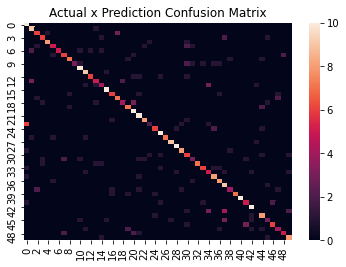

In [0]:
from sklearn import metrics
import seaborn as sns
confusion = metrics.confusion_matrix(test_labels.cpu(), predictions)
sns.heatmap(confusion).set_title("Actual x Prediction Confusion Matrix")

In [0]:
test_df
test_labels = torch.tensor(test_df.author_id.values)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 22, 22, 22, 22, 

XGBoost

In [0]:
# Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost

In [0]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}
classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,n_jobs=-1,verbose=3)
# random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [0]:
random_search.fit(train_features.cpu().numpy(),train_labels.numpy().ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
classifier=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
classifier.fit(train_features.cpu(), train_labels.cpu())
predictions = classifier.predict(test_features.cpu())

In [0]:
print(classification_report(test_labels.cpu(),predictions))

              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.56      0.50      0.53        10
           2       0.57      0.80      0.67        10
           3       0.46      0.60      0.52        10
           4       0.78      0.70      0.74        10
           5       0.45      0.50      0.48        10
           6       0.80      0.40      0.53        10
           7       0.71      0.50      0.59        10
           8       0.75      0.90      0.82        10
           9       0.78      0.70      0.74        10
          10       0.78      0.70      0.74        10
          11       0.67      0.80      0.73        10
          12       0.62      0.80      0.70        10
          13       0.67      0.80      0.73        10
          14       0.46      0.60      0.52        10
          15       0.75      0.90      0.82        10
          16       0.70      0.70      0.70        10
          17       0.89    